In [ ]:
#Conditional Calibration Package
pip install conditionalconformal

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q torch-geometric
!pip install umap-learn
!pip install ogb

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE
from torch_geometric.data import NeighborSampler
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import NELL
from torch_geometric.datasets import CitationFull
from torch_geometric.datasets import CoraFull
from torch_geometric.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import os.path as osp
import pandas as pd
import numpy as np
import collections
import random
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from conditionalconformal.synthetic_data import generate_cqr_data, indicator_matrix
from conditionalconformal import CondConf

from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from tqdm import tqdm


In [ ]:
#Construct Data (X,Y) 1-d case for better illustrations


def generate_cqr_data(seed,n_train,n_calib,n_test):


    n_train = n_train + n_calib

    def f(x):

        ax = 0*x
        for i in range(len(x)):
            ax[i] = np.random.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*np.random.randn(1)
            ax[i] += 10*(np.random.uniform(0,1,1)<0.01)*np.random.randn(1)
        return ax.astype(np.float32)

    #x sampled from uniform[0,5] for better visualizing
    x_train = np.random.uniform(0, 5.0, size=n_train).astype(np.float32)


    x_test = np.random.uniform(0, 5.0, size=n_test).astype(np.float32)

    y_train = f(x_train)
    y_test = f(x_test)


    x_train = np.reshape(x_train,(n_train,1))
    x_test = np.reshape(x_test,(n_test,1))

    train_set_size = len(y_train) - n_calib
    x_train_final = x_train[ : train_set_size]
    x_calib = x_train[train_set_size : ]
    y_train_final = y_train[ : train_set_size]
    y_calib = y_train[train_set_size : ]

    return x_train_final, y_train_final, x_calib, y_calib, x_test, y_test

#To indicate which data belongs to which group
#Data is row and column represents groups
def indicator_matrix(scalar_values, disc):
    scalar_values = np.array(scalar_values)


    intervals = [(disc[i], disc[i + 1]) for i in range(len(disc) - 1)]


    matrix = np.zeros((len(scalar_values), len(intervals)))

    for i, value in enumerate(scalar_values):
        for j, (a, b) in enumerate(intervals):
            if a <= value < b:
                matrix[i, j] = 1

    return matrix


In [ ]:
n_train = 1500
n_calib = 500
n_test = 500
x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(30,n_train,n_calib,n_test)

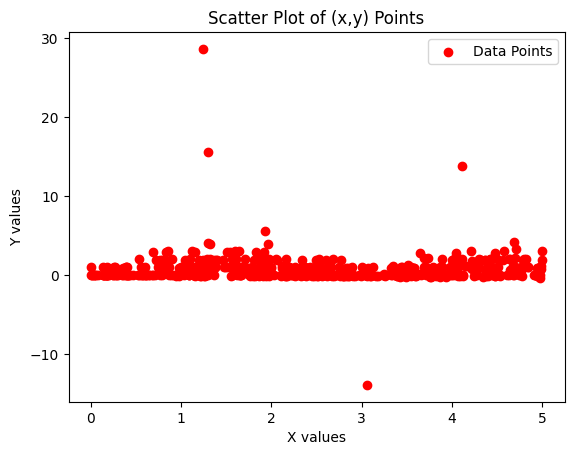

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x_test, y_test, color='red', marker='o', label='Data Points')


# Adding labels and title
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Scatter Plot of (x,y) Points')
plt.legend()

plt.show()

In [ ]:
x_all = np.concatenate((x_train_final, x_calib, x_test), axis=0)
y_all = np.concatenate((y_train_final,y_calib,y_test),axis = 0)

In [ ]:
#Erdos Renyi Graph with probability p =0.3 as the graph model
from torch_geometric.data import Data

num_nodes = n_train+n_calib+n_test
adj_matrix = np.random.rand(num_nodes, num_nodes) < 0.3
np.fill_diagonal(adj_matrix, 0)
rows, cols = np.where(adj_matrix)
edge_index = torch.tensor([rows, cols], dtype=torch.long)
features = torch.tensor(x_all)
labels = torch.tensor(y_all)

data = Data(x=features, edge_index=edge_index, y=labels)

print(data)

Data(x=[2500, 1], edge_index=[2, 1874074], y=[2500])


In [ ]:

print(data)
print(data.x)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = data.x.to(device)
y = data.y.squeeze().to(device)


In [ ]:
random.seed(100)

In [ ]:
#train would be first 1500, calibration 1501-2000,test 2001-2500
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[list(range(n_train))] = True
cali_mask = torch.zeros(num_nodes,dtype=torch.bool)
cali_mask[list(range(n_train,n_train+n_calib))] = True
test_mask = torch.zeros(num_nodes,dtype=torch.bool)
test_mask[list(range(n_train+n_calib,n_train+n_calib+n_test))] = True
print(train_mask.sum())
print(test_mask.sum())
print(cali_mask.sum())

In [ ]:
train_loader = NeighborSampler(
    data.edge_index, node_idx=train_mask,
    sizes=[5,5,5], batch_size=(n_train+1), shuffle=False,
)

In [ ]:
class SAGE(torch.nn.Module):
    def __init__(self,in_channels,hidden_channels,out_channels,num_layers = 3):
        super(SAGE,self).__init__()

        self.numlayers = num_layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels,hidden_channels))
        for i in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels,hidden_channels))
        self.convs.append(SAGEConv(hidden_channels,out_channels))
    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
    def forward(self,x,adjs):
        for i ,(edge_index,_,size) in enumerate(adjs):
            xs = []
            x_target = x[:size[1]]#x should be a list prioritizing target nodes
            x = self.convs[i]((x,x_target),edge_index)
            if i != self.numlayers -1:
                x = F.relu(x)
                x = F.dropout(x,p=0.5,training=self.training)
            xs.append(x)
            if i == 0:
                x_all = torch.cat(xs, dim=0)
                layer_1_embeddings = x_all
            elif i == 1:
                x_all = torch.cat(xs, dim=0)
                layer_2_embeddings = x_all
            elif i == 2:
                x_all = torch.cat(xs, dim=0)
                layer_3_embeddings = x_all
        return layer_1_embeddings, layer_2_embeddings, layer_3_embeddings
#To see the performance on using whole neighborhood edges with three layers
    def inference(self, x,adjs):
        for i ,(edge_index,_,size) in enumerate(adjs):
            xs = []
            x_target = x[:size[1]]#x should be a list prioritizing target nodes
            x = self.convs[i]((x,x_target),edge_index)
            if i != self.numlayers -1:
                x = F.relu(x)
                x = F.dropout(x,p=0.5,training=self.training)
            xs.append(x)
            if i == 0:
                x_all = torch.cat(xs, dim=0)
                layer_1_embeddings = x_all
            elif i == 1:
                x_all = torch.cat(xs, dim=0)
                layer_2_embeddings = x_all
            elif i == 2:
                x_all = torch.cat(xs, dim=0)
                layer_3_embeddings = x_all
        return layer_1_embeddings, layer_2_embeddings, layer_3_embeddings


In [ ]:
model = SAGE(data.num_features, 2, 1, num_layers=3)

model.reset_parameters()
#We only input the initializing variables
model = model.to(device)

In [ ]:
print(model)

SAGE(
  (convs): ModuleList(
    (0): SAGEConv(1, 2, aggr=mean)
    (1): SAGEConv(2, 2, aggr=mean)
    (2): SAGEConv(2, 1, aggr=mean)
  )
)


In [ ]:
def train(epoch):
    model.train()
    i=0
    for batch_size,n_id,adjs in train_loader:
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()
        l1_emb, l2_emb, l3_emb = model(x[n_id], adjs)
        loss = F.mse_loss(l3_emb,y[n_id][:batch_size].unsqueeze(1))
        loss.backward()
        optimizer.step()
        i+=loss

    return i



In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.005)

for epoch in range(1,100):
    loss = train(epoch)
    print(loss)

In [ ]:

CaliGraph_loader = NeighborSampler(data.edge_index,node_idx = cali_mask
  , sizes = [5,5,5],batch_size = 5000,shuffle=False)

In [ ]:
TestGraph_loader  = NeighborSampler(data.edge_index,node_idx = test_mask
  , sizes = [5,5,5],batch_size = 5000,shuffle=False)

In [ ]:
CaliandTestGraph_loader = NeighborSampler(data.edge_index,node_idx = test_mask+cali_mask
  , sizes = [5,5,5],batch_size = 5000,shuffle=False)

In [ ]:
#function the takes graph loader to the third layer embedding and the fn which is
#a matrix in the form [x,predicted y]
def inference_1(subgraph_loader):
    model.eval()
    total_loss = total_correct = 0
    for batch_size,n_id,adjs in subgraph_loader:

        emb1,emb2,emb3 = model(x[n_id],adjs)

        c = x[n_id][:batch_size]
        fn = torch.cat((c, emb3), dim=1)


    return emb3,fn


In [ ]:
emb3,fn = inference_1(CaliandTestGraph_loader)

fn = fn.detach().cpu().numpy()

In [ ]:
#x is input vector and output is predicted label vector
def get_xhat(x):
  xhat= np.ones((x.shape[0], 1))
  for j in range(x.shape[0]):
   for i in range((cali_mask+test_mask).sum()):
     if(x[j] == fn[i,0]).any():
      xhat[j]=fn[i,1]

  return xhat

In [ ]:
#we're using score to be absolute residual
def score_fn(x,y):
  for i in range((cali_mask+test_mask).sum()):
    if(x == fn[i,0]).any():
      return y-fn[i,1]
      break



In [ ]:
def score_inv_fn_ub(s,x):
  for i in range((cali_mask+test_mask).sum()):
    if(x==fn[i,0]).any():
      return [-np.inf,fn[i,1]+s]
      break


In [ ]:
def score_inv_fn_lb(s,x):
  for i in range((cali_mask+test_mask).sum()):
    if(x==fn[i,0]).any():
      return[fn[i,1]+s,np.inf]
      break




In [ ]:
#our grroup is divided into [0,0.5,1,1.5......5]
eps = 0.5
disc = np.arange(0, 5 + eps, eps)

def phi_fn_groups(x):
    return indicator_matrix(x, disc)


# coverage on Gaussians with mu=loc and sd=scale
# scale = 1 for x != [1.5, 3.5]
eval_locs = [1.5, 3.5]
eval_scale = 0.2

other_locs = [0.5, 2.5, 4.5]
other_scale = 1

def phi_fn_shifts(x):
    shifts = [norm.pdf(x, loc=loc, scale=eval_scale).reshape(-1,1)
                   for loc in eval_locs]
    shifts.extend([norm.pdf(x, loc=loc, scale=other_scale).reshape(-1,1)
                   for loc in other_locs])
    shifts.append(np.ones((x.shape[0], 1)))
    return np.concatenate(shifts, axis=1)

# intercept only phi_fn
def phi_fn_intercept(x):
    return np.ones((x.shape[0], 1))


In [ ]:
# experiment = 'groups'
phi_fn = phi_fn_groups
infinite_params = {}

In [ ]:
cond_conf = CondConf(score_fn, phi_fn, infinite_params)
cond_conf.setup_problem(x_calib, y_calib)


In [ ]:
n_test = len(x_test)
alpha = 0.1
lbs = np.zeros((n_test,))
ubs = np.zeros((n_test,))
i = 0
for x_t in tqdm(x_test):
    res = cond_conf.predict(alpha / 2, x_t, score_inv_fn_lb)
    lbs[i] = res[0]
    res = cond_conf.predict(1 - alpha / 2, x_t, score_inv_fn_ub)
    ubs[i] = res[1]
    i += 1

In [ ]:
#Compute the quantile to produce split conformal prediction
q = np.quantile(np.abs(get_xhat(x_calib) - y_calib),
                np.ceil((len(x_calib) + 1) * (0.9)) / len(x_calib),)

In [ ]:
#print(x_test)
#print(y_test)

print(get_xhat(x_test))

In [ ]:
def get_marginalcovergage_condi():
  j=0
  for i in range(len(x_test)):
    if((y_test[i]<=ubs[i]) & (y_test[i]>=lbs[i])):
      j+=1

  return j/len(x_test)
def get_marginalcovergage_split():
  j=0
  x_hat = get_xhat(x_test)
  for i in range(len(x_test)):
    if((y_test[i]>=x_hat[i]-q )& (y_test[i]<= x_hat[i]+q)):
      j+=1

  return j/len(x_test)



In [ ]:
marginal_covergage_split = get_marginalcovergage_split()
marginal_covergage_condi = get_marginalcovergage_condi()


In [ ]:
print(marginal_covergage_condi)
print(marginal_covergage_split)

Text(0.5, 1.0, 'Conditional Calibration')

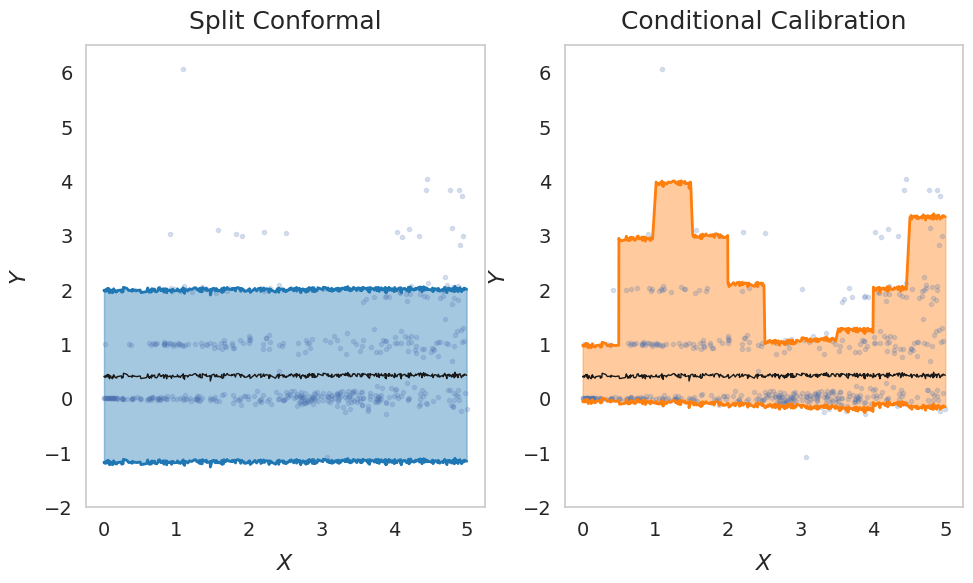

In [ ]:

q = np.quantile(np.abs(get_xhat(x_calib) - y_calib),
                np.ceil((len(x_calib) + 1) * (0.9)) / len(x_calib),)

cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(17.5, 6)

sort_order = np.argsort(x_test[0:n_test,0])
x_test_s = x_test[sort_order]
y_test_s = y_test[sort_order]
y_test_hat = get_xhat(x_test[sort_order])
lb = lbs[sort_order]
ub = ubs[sort_order]

ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax1.plot(x_test_s, y_test_hat, lw=1, color='k')
ax1.plot(x_test_s, y_test_hat + q, color=cp[0], lw=2)
ax1.plot(x_test_s, y_test_hat - q, color=cp[0], lw=2)

ax1.set_ylim(-2,6.5)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Split Conformal", fontsize=18, pad=12)
ax1.fill_between(x_test_s.flatten(), y_test_hat.flatten() - q, y_test_hat.flatten() + q,
                 color=cp[0], alpha=0.4, label='split prediction interval')


ax2 = fig.add_subplot(1, 3, 2, sharex = ax1, sharey = ax1)
ax2.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax2.plot(x_test_s, y_test_hat, color='k', lw=1)
ax2.plot(x_test_s, ub, color=cp[1], lw=2)
ax2.plot(x_test_s, lb, color=cp[1], lw=2)
ax2.fill_between(x_test_s.flatten(), lb,
                 ub,
                 color=cp[1], alpha=0.4, label='conditional calibration')
ax2.tick_params(axis='both', which='major', direction='out', labelsize=14)
ax2.set_xlabel("$X$", fontsize=16, labelpad=10)
ax2.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax2.set_title("Conditional Calibration", fontsize=18, pad=12)





In [ ]:
#Set up the problem by shifts
cond_conf = CondConf(score_fn, phi_fn_shifts, infinite_params)
cond_conf.setup_problem(x_calib, y_calib)

n_test = len(x_test)
alpha = 0.1
lbs = np.zeros((n_test,))
ubs = np.zeros((n_test,))
i = 0
for x_t in tqdm(x_test):
    res = cond_conf.predict(alpha / 2, x_t, score_inv_fn_lb)
    lbs[i] = res[0]
    res = cond_conf.predict(1 - alpha / 2, x_t, score_inv_fn_ub)
    ubs[i] = res[1]
    i += 1

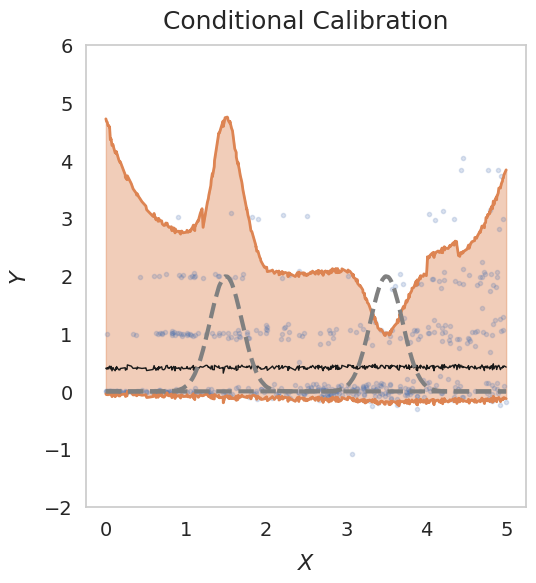

In [ ]:


cp = sns.color_palette()
sns.set(font="DejaVu Sans")
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure()
fig.set_size_inches(12.5, 6)


sort_order = np.argsort(x_test[0:n_test,0])
x_test_s = x_test[sort_order]
y_test_s = y_test[sort_order]
y_test_hat = get_xhat((x_test[sort_order]))
lb_ag = lbs[sort_order]
ub_ag = ubs[sort_order]


ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x_test_s, y_test_s, '.', alpha=0.2)
ax1.plot(x_test_s, y_test_hat, lw=1, color='k')
ax1.plot(x_test_s, ub_ag, color=cp[1], lw=2)
ax1.plot(x_test_s, lb_ag, color=cp[1], lw=2)
ax1.fill_between(x_test_s.flatten(), lb_ag, ub_ag,
                 color=cp[1], alpha=0.4, label='conditional calibration')



ax1.set_ylim(-2,6)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel("$X$", fontsize=16, labelpad=10)
ax1.set_ylabel("$Y$", fontsize=16, labelpad=10)
ax1.set_title("Conditional Calibration", fontsize=18, pad=12)


for loc in eval_locs:
    ax1.plot(x_test_s, norm.pdf(x_test_s, loc=loc, scale=eval_scale), color='grey', ls='--', lw=3)
